In [1]:
import pandas as pd
import numpy as np
import json
import requests
import datetime as dt
from datetime import date, timedelta, datetime
from tqdm.notebook import tqdm
import time
import osmnx as ox
import geopandas as gpd
import fiona
import shapely.geometry as geom

ox.config(log_console=True, use_cache=True)

c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\geopandas\array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\Ibrahem.Alsalamh\AppData\Local\Temp\ipykernel_2524\432063784.py:30: UserWarning: `keep_geom_type=True` in overlay resulted in 36615 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  inrix_osm_data_shp=gpd.overlay(osm_network_joined,inrix_osm_data_shp, how='union')


(37797, 23)


  0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Ibrahem.Alsalamh\Anaconda3\envs\geoenv\lib\site-packages\geopandas\array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(37797, 45)


<AxesSubplot:>

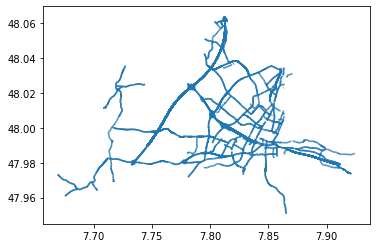

In [147]:
## Get Inrix live data (1min), adjust them and join them with OSM
url = 'http://inrixfreiburg.traffgoroad.com/inrix_freiburg.json'
username = 'arup'
password = 'RJXvRaFMk:'
response=requests.get(url, auth=(username, password))
response_json=response.json()
data_segment=pd.DataFrame()

for result in response_json['result']['segmentSpeeds']:
    segments=result['segments']
    data=pd.DataFrame(segments)
    data['date']=datetime.today().strftime('%Y-%m-%d')
    data['time']=dt.datetime.now().strftime('%H:%M')
    data_segment=pd.concat([data_segment,data])
data_segment.to_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\inrix_data_live.csv')
path_shp_inrix=r'C:\Users\Ibrahem.Alsalamh\Downloads\Germany_Baden_Wurttemberg_shapefile'
inrix_data_csv=pd.read_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\inrix_data_live.csv')
inrix_data_shp=gpd.read_file(path_shp_inrix)
inrix_data_shp=inrix_data_shp[['XDSegID','RoadNumber','RoadName','PostalCode','geometry']]
inrix_data_shp=pd.merge(inrix_data_csv, inrix_data_shp,left_on='code',right_on='XDSegID',how='left')
inrix_data_shp=inrix_data_shp.add_suffix('_inrix')
inrix_data_shp = gpd.GeoDataFrame(inrix_data_shp, crs='EPSG:4326', geometry=inrix_data_shp.geometry_inrix)
inrix_data_shp.drop(['XDSegID_inrix','geometry_inrix'],inplace=True,axis=1)
# Combine with OSM network
osm_network_joined=gpd.read_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\shp\osm_data\edited')
road_list=['motorway','motorway_link', 'trunk','trunk_link', 'primary','primary_link','secondary','secondary_link','tertiary','tertiary_link','edited_inrix']
osm_network_joined2=osm_network_joined[osm_network_joined.highway_os.isin(road_list)]
inrix_osm_data_shp=gpd.sjoin_nearest(osm_network_joined2,inrix_data_shp, how='left',max_distance=0.00001)
inrix_osm_data_shp.drop('index_right',inplace=True,axis=1)
inrix_osm_data_shp=gpd.overlay(osm_network_joined,inrix_osm_data_shp, how='union')
inrix_osm_data_shp.drop(['osmid_osm_2', 'oneway_osm_2', 'lanes_osm_2', 'ref_osm_2',
       'highway_os_2', 'road_name__2', 'city_distr_2', 'inrix_netw_2',
       'Unnamed: 0_inrix','inrix_netw_2','inrix_netw_1'],inplace=True,axis=1)
inrix_osm_data_shp.columns = inrix_osm_data_shp.columns.str.rstrip("_1")
inrix_osm_data_shp=inrix_osm_data_shp.loc[inrix_osm_data_shp['highway_os']!='track']
print(inrix_osm_data_shp.shape)

## Download Telramm data from today 
# POSTtraffic snapshot Telraam to get a list of segment ids
data_segment=pd.DataFrame()
start_date=dt.date.today()
url = "https://telraam-api.net/v1/reports/traffic_snapshot"
payload = "{\r\n    \"time\":\"" +str(start_date)+ " 00:00:00Z\",\r\n    \"contents\":\"full\",\r\n    \"area\":\"7.8359048,47.9963918,10\"\r\n}\r\n"
headers = {'X-Api-Key': '9bDufSS8AE2NAOT2R5YtR9vutyukJlZh6ZQyhTnQ'}
response = requests.request("POST", url, headers=headers, data=payload,)
response_json=response.json()
response_json=pd.json_normalize(response_json['features'])  
data_segment=pd.concat([data_segment,response_json])
segment_ids_list=data_segment['properties.segment_id'].unique().tolist()
geometry_data=data_segment[['properties.segment_id','geometry.coordinates']].drop_duplicates(subset='properties.segment_id')
# POSTtraffic Telraam to get historical data
data_repot=pd.DataFrame()
for segment_id in tqdm(segment_ids_list):
  time.sleep(2)
  end_date = dt.date.today()
  payload = "{\r\n  \"level\": \"segments\",\r\n  \"format\": \"per-hour\",\r\n  \"id\": \""+str(segment_id)+"\",\r\n  \"time_start\": \"" +str(start_date)+ " 00:00:00Z\",\r\n  \"time_end\": \""+ str(end_date)+ " 23:00:00Z\"\r\n}"
  url = "https://telraam-api.net/v1/reports/traffic"
  headers = {'X-Api-Key': '9bDufSS8AE2NAOT2R5YtR9vutyukJlZh6ZQyhTnQ'}
  response = requests.request("POST", url, headers=headers, data=payload)
  response_json=response.json()

  for result in response_json['report']:
      data=pd.DataFrame([result])
      data_repot=pd.concat([data_repot,data])
# Bring the location data
data_repot=pd.merge(left=data_repot,right=geometry_data,left_on='segment_id', right_on='properties.segment_id')
data_repot.drop('properties.segment_id',inplace=True, axis=1)
data_repot['date'] = pd.to_datetime(data_repot['date'])
data_repot = data_repot[data_repot['date']==data_repot['date'].max()]
data_repot.to_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\telraam_data_freiburg_live.csv')
# Read and transfer Telraam into shapefile and then intersect them with the osm data  
telraam_data_shp=pd.read_csv(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\telraam_data_freiburg_live.csv',index_col=0)
telraam_data_shp['geometry.coordinates_start']= telraam_data_shp['geometry.coordinates'].str.split(']').str[0].str.strip('[')
telraam_data_shp[['start_x','start_y']] = telraam_data_shp['geometry.coordinates_start'].str.split(',',expand=True).astype(float)
telraam_data_shp['geometry.coordinates_end']= telraam_data_shp['geometry.coordinates'].str.split('[').str[-1].str.strip(']')
telraam_data_shp[['end_x','end_y']] = telraam_data_shp['geometry.coordinates_end'].str.split(',',expand=True).astype(float)
telraam_data_shp['geometry'] = telraam_data_shp.apply(lambda x: geom.LineString([(x['start_x'], x['start_y']) , (x['end_x'], x['end_y'])]), axis = 1)
telraam_data_shp['midpoint'] = telraam_data_shp.apply(lambda row: row['geometry'].centroid, axis=1) #Find centroid
telraam_data_shp=telraam_data_shp.add_suffix('_telraam')
telraam_data_shp = gpd.GeoDataFrame(telraam_data_shp, crs='EPSG:4326', geometry=telraam_data_shp.midpoint_telraam)
telraam_data_shp.drop(['geometry.coordinates_telraam', 'geometry_telraam','geometry.coordinates_start_telraam','geometry.coordinates_end_telraam','start_x_telraam','start_y_telraam','end_x_telraam','end_y_telraam','midpoint_telraam'],inplace=True, axis=1)

# Combine OSM, inrix and Telraam data
telraam_data_joined=gpd.sjoin_nearest(inrix_osm_data_shp, telraam_data_shp, how='left',max_distance=0.00001)
telraam_data_joined.drop(['index_right'],inplace=True,axis=1)
print(telraam_data_joined.shape)
telraam_data_ref=pd.read_csv('telraam_data_summary_ref.csv')
telraam_data_joined=pd.merge(telraam_data_joined,telraam_data_ref, left_on='segment_id_telraam',right_on='segment_id_telraam_ref',how='left')
telraam_data_joined['time_telraam'] = pd.DatetimeIndex(telraam_data_joined['date_telraam']).hour
telraam_data_joined=telraam_data_joined.fillna(0)
telraam_data_joined=telraam_data_joined.loc[(telraam_data_joined[['code_inrix','segment_id_telraam']] != 0).any(axis=1)]

telraam_data_joined['cur_to_ref_speed_inrix']=np.round(100*(telraam_data_joined['speed_inrix']/telraam_data_joined['reference_inrix']),decimals=2)
telraam_data_joined['cur_to_avrg_hgv_telraam']=np.round(100*(telraam_data_joined['heavy_telraam']/telraam_data_joined['heavy_telraam_ref']),decimals=2)
telraam_data_joined['cur_to_avrg_car_telraam']=np.round(100*(telraam_data_joined['car_telraam']/telraam_data_joined['car_telraam_ref']),decimals=2)
telraam_data_joined['cur_to_avrg_bike_telraam']=np.round(100*(telraam_data_joined['bike_telraam']/telraam_data_joined['bike_telraam_ref']),decimals=2)
telraam_data_joined['cur_to_avrg_ped_telraam']=np.round(100*(telraam_data_joined['pedestrian_telraam']/telraam_data_joined['pedestrian_telraam_ref']),decimals=2)
telraam_data_joined['cur_to_avrg_v85_telraam']=np.round(100*(telraam_data_joined['v85_telraam']/telraam_data_joined['v85_telraam_ref']),decimals=2)

telraam_data_joined['veh_total_telrram_cur']=telraam_data_joined['heavy_telraam']+telraam_data_joined['car_telraam']
telraam_data_joined['veh_total_telrram_ref']=telraam_data_joined['heavy_telraam_ref']+telraam_data_joined['car_telraam_ref']
telraam_data_joined['cur_to_avrg_veh_telraam']=np.round(100*(telraam_data_joined['veh_total_telrram_cur']/telraam_data_joined['veh_total_telrram_ref']),decimals=2)
telraam_data_joined=telraam_data_joined.fillna(0)
telraam_data_joined['congestion_level_speed_inrix'] = ['no data' if x<=0 else'very congested' if 0<x<60 else 'congested' if 60<=x<80 else 'slightly congested' if 80<=x<100 else 'no congestion' for x in telraam_data_joined['cur_to_ref_speed_inrix']]
telraam_data_joined['congestion_level_car_telraam'] = ['no data' if x<=0 else 'no congestion' if 0<x<60 else 'slightly congested' if 60<=x<80 else 'congested' if 80<=x<100 else 'very congestion' for x in telraam_data_joined['cur_to_avrg_car_telraam']]
telraam_data_joined['congestion_level_hgv_telraam'] = ['no data' if x<=0 else 'no congestion' if 0<x<60 else 'slightly congested' if 60<=x<80 else 'congested' if 80<=x<100 else 'very congestion' for x in telraam_data_joined['cur_to_avrg_hgv_telraam']]
telraam_data_joined=telraam_data_joined[['osmid_osm','code_inrix','time_inrix','average_inrix','reference_inrix',
'speed_inrix','score_inrix','speedBucket_inrix','cur_to_ref_speed_inrix','congestion_level_speed_inrix','segment_id_telraam',
'time_telraam','uptime_telraam','uptime_telraam_ref','v85_telraam','heavy_telraam','car_telraam','bike_telraam','pedestrian_telraam',
'cur_to_avrg_hgv_telraam','cur_to_avrg_car_telraam','cur_to_avrg_veh_telraam','cur_to_avrg_bike_telraam','cur_to_avrg_ped_telraam','cur_to_avrg_v85_telraam',
'congestion_level_car_telraam','congestion_level_hgv_telraam','year_telraam_ref','count_days_telraam_ref','road_name','highway_os','city_distr','geometry']]
cols_at_end = ['geometry']
telraam_data_joined = telraam_data_joined[[c for c in telraam_data_joined if c not in cols_at_end] + [c for c in cols_at_end if c in telraam_data_joined]]
telraam_data_joined = gpd.GeoDataFrame(telraam_data_joined, crs='EPSG:4326', geometry=telraam_data_joined.geometry)
telraam_data_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\final_output\final_data_joined.geojson',driver="GeoJSON")

telraam_data_joined.plot()


In [145]:
telraam_data_joined.to_file(r'C:\Users\Ibrahem.Alsalamh\OneDrive - Arup\Freiburg smart city\traffic data\final_output\final_data_joined.geojson',driver="GeoJSON")


In [ ]:
# no data pre c19
# no data for full year 
# 3-4 hours time lag
# check the directional data 
# Problem with inrix shape file
# Add Telraam time to the final data 